## Mambaで正弦波のモデリングを行う

このノートブックでは、系列データのモデリング事例として正弦波のモデリングをMambaで行うサンプルを示す。

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from mamba import Mamba

# ハイパーパラメータの設定
input_size = 1  # 入力は正弦波の1点
hidden_size = 2 # 隠れ状態のサイズ
output_size = 1 # 出力は次の正弦波の1点
expand_factor = 256 # 入力の情報を拡大する（埋め込み）次元数
conv_size = 2 # シーケンス前後の畳み込み次元数
sequence_length = 100 # 系列の長さ
batch_size = 1 # バッチサイズ
num_epochs = 100 # エポック数
learning_rate = 0.01 # 学習率
noise_level = 0.1 # 正弦波に加えるノイズのレベル

**説明:**

*   必要なライブラリをインポートし、ハイパーパラメータを設定します。
*   `input_size`: 各タイムステップにおける入力データの次元数（正弦波の1点なので1）。
*   `hidden_size`: 隠れ状態のサイズ。
*   `output_size`: 出力の次元数（次のタイムステップの正弦波の値なので1）。
*   `expand_factor`: 入力の情報を拡大する（埋め込み）次元数
*   `conv_size`: シーケンス前後の畳み込み次元数
*   `sequence_length`: 時系列データの長さ。
*   `batch_size`: ミニバッチのサイズ。
*   `num_epochs`: 学習のエポック数。
*   `learning_rate`: 学習率。
*   `noise_level`: 正弦波に加えるノイズのレベル（標準偏差）。この値を調整することで、モデルのロバスト性を評価できます。

In [39]:
# Mambaモデルの定義
class SimpleMamba(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, expand, conv_size):
        super(SimpleMamba, self).__init__()
        self.mamba = Mamba(
            d_model=input_size,
            d_state=hidden_size,
            d_conv=conv_size,
            expand_factor=expand_factor) # Mamba層

    def forward(self, x):
        
        out = self.mamba(x)

        return out

**説明:**

*   `SimpleRNN`クラスは、RNNモデルを定義します。
*   `__init__`メソッドで、RNN層と全結合層を定義します。
    *   `Mamba`: Mamba層を定義します。`input_size`, `hidden_size`, `expand_factor`, `conv_size`は、上で定義したハイパーパラメータを使用します。
    *   `nn.Linear`: 全結合層を定義します。Mamba層の出力を、`output_size`の次元に変換します。
*   `forward`メソッドで、順伝播の処理を定義します。
    *   `out, _ = self.mamba(x)`: Mamba層に入力データを渡します。
    *   `out = self.fc(out)`: Mamba層の出力を全結合層に入力し、出力を得ます。

In [40]:
# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルのインスタンス化
model = SimpleMamba(input_size, hidden_size, output_size, expand_factor, conv_size).to(device)

# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss() # 平均二乗誤差
optimizer = optim.AdamW(model.parameters(), lr=learning_rate) # AdamW optimizer

**説明:**

*   `device`: CUDAが利用可能な場合はGPUを使用し、そうでない場合はCPUを使用するようにデバイスを設定します。
*   `model`: `SimpleMamba`クラスのインスタンスを作成し、指定したデバイスに配置します。
*   `criterion`: 損失関数として、平均二乗誤差を使用します。正弦波の予測は回帰問題なので、適切な損失関数です。
*   `optimizer`: 最適化アルゴリズムとして、AdamWを使用します。

In [41]:
# データの生成 (正弦波にノイズを追加)
def generate_sine_wave(sequence_length, batch_size, noise_level=0.1):
    time = np.linspace(0, 10 * np.pi, sequence_length + 1, endpoint=True)
    sine_wave = np.sin(time)

    # ノイズの生成
    noise = np.random.normal(0, noise_level, size=sine_wave.shape)
    noisy_sine_wave = sine_wave + noise

    x = []
    y = []
    for i in range(sequence_length):
        x.append(noisy_sine_wave[i:i+1])
        y.append(noisy_sine_wave[i+1:i+2])

    x = np.array(x).reshape(sequence_length, 1)
    y = np.array(y).reshape(sequence_length, 1)

    x = np.tile(x, (batch_size, 1, 1))
    y = np.tile(y, (batch_size, 1, 1))

    x = torch.tensor(x, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return x, y

**説明:**

*   `generate_sine_wave` 関数は、正弦波にノイズを加えた時系列データを生成します。
*   `time = np.linspace(0, 100, sequence_length + 1, endpoint=True)`: 時間軸を作成します。
*   `sine_wave = np.sin(time)`: 正弦波を生成します。
*   `noise = np.random.normal(0, noise_level, size=sine_wave.shape)`: 正規分布に従うノイズを生成します。`noise_level` は、セル1で定義したハイパーパラメータを使用します。
*   `noisy_sine_wave = sine_wave + noise`: 生成されたノイズを正弦波に加算して、ノイズを含んだ正弦波を作成します。
*   `x`は入力データ（ノイズが加わった正弦波）、`y`はターゲットデータ（タイムステップを1つずらした正弦波の値）です。

In [44]:
# 学習ループ
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # データの生成
    x, y = generate_sine_wave(sequence_length, batch_size, noise_level)

    # 順伝播
    outputs = model(x)
    loss = criterion(outputs, y)

    # 逆伝播と最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 損失の表示
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0203
Epoch [20/100], Loss: 0.0255
Epoch [30/100], Loss: 0.0221
Epoch [40/100], Loss: 0.0192
Epoch [50/100], Loss: 0.0219
Epoch [60/100], Loss: 0.0252
Epoch [70/100], Loss: 0.0249
Epoch [80/100], Loss: 0.0199
Epoch [90/100], Loss: 0.0191
Epoch [100/100], Loss: 0.0192


**説明:**

*   学習ループは、指定されたエポック数だけ繰り返されます。
*   各エポックにおいて、以下の処理を行います。
    *   `x, y = generate_sine_wave(sequence_length, batch_size, noise_level)`: ノイズを含む正弦波データを生成します。
    *   `outputs = model(x)`: モデルに入力データを渡して、出力を得ます。
    *   `loss = criterion(outputs, y)`: 損失を計算します。
    *   `optimizer.zero_grad()`: 勾配をゼロに初期化します。
    *   `loss.backward()`: 勾配を計算します。
    *   `optimizer.step()`: モデルのパラメータを更新します。
    *   定期的に損失を表示します。

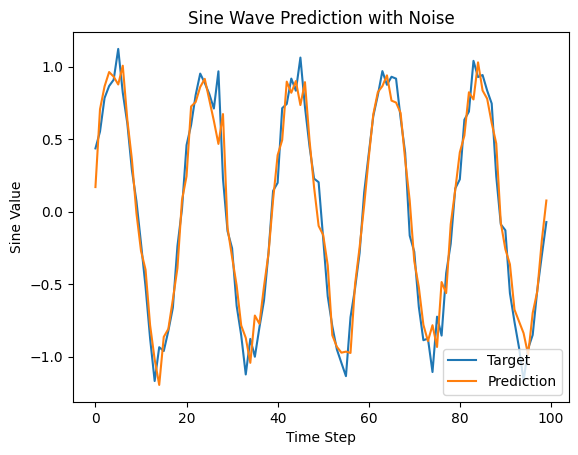

In [45]:
# テストと可視化
model.eval() # 評価モードに設定
with torch.no_grad():
    # テストデータの生成
    x_test, y_test = generate_sine_wave(sequence_length, batch_size=1, noise_level=noise_level)  # バッチサイズを1に
    predicted = model(x_test)

    # 結果の可視化
    #plt.plot(x_test[0, :, 0].cpu().numpy(), label='Input') # 入力データをプロット
    plt.plot(y_test[0, :, 0].cpu().numpy(), label='Target') # ターゲットデータをプロット
    plt.plot(predicted.squeeze().cpu().numpy(), label='Prediction') # 予測結果をプロット
    plt.legend()
    plt.title('Sine Wave Prediction with Noise') # タイトルを修正
    plt.xlabel('Time Step')
    plt.ylabel('Sine Value')
    plt.show()

**説明:**

*   テストフェーズでは、モデルの汎化性能を評価します。
*   `model.eval()`: モデルを評価モードに設定します。
*   `x_test, y_test = generate_sine_wave(sequence_length, batch_size=1, noise_level=noise_level)`: テストデータを生成します。
*   `predicted = model(x_test)`: モデルに入力データを渡して、予測結果を得ます。
*   可視化のために、Matplotlibを使用してグラフを作成します。
    *   入力データ、ターゲットデータ、予測データをそれぞれプロットします。
    *   予測データは、1ステップ右にずらして表示することで、予測の遅れや先行を視覚的に確認できます。
    *   グラフに凡例、タイトル、軸ラベルを追加します。

この詳細な説明で、各セルの役割とコードの動作をより深く理解できるはずです。